In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
from collections import Counter
import os
import time
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/cnn_dataset.zip" -d "/content/cnn-dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/cnn-dataset/vehicles/5499.jpg  
  inflating: /content/cnn-dataset/vehicles/55.jpg  
  inflating: /content/cnn-dataset/vehicles/550.jpg  
  inflating: /content/cnn-dataset/vehicles/5500.jpg  
  inflating: /content/cnn-dataset/vehicles/5501.jpg  
  inflating: /content/cnn-dataset/vehicles/5502.jpg  
  inflating: /content/cnn-dataset/vehicles/5503.jpg  
  inflating: /content/cnn-dataset/vehicles/5504.jpg  
  inflating: /content/cnn-dataset/vehicles/5505.jpg  
  inflating: /content/cnn-dataset/vehicles/5506.jpg  
  inflating: /content/cnn-dataset/vehicles/5507.jpg  
  inflating: /content/cnn-dataset/vehicles/5508.jpg  
  inflating: /content/cnn-dataset/vehicles/5509.jpg  
  inflating: /content/cnn-dataset/vehicles/551.jpg  
  inflating: /content/cnn-dataset/vehicles/5510.jpg  
  inflating: /content/cnn-dataset/vehicles/5511.jpg  
  inflating: /content/cnn-dataset/vehicles/5512.jpg  
  inflating: /content/cnn-dataset/v

**Step 1 :** Creating a Deeper VGG16 Model

In [ ]:
#Loading Dataset:

dataset_path = "/content/cnn-dataset"

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

class_counts = Counter(full_dataset.targets)
print("Class Distribution:", class_counts)


Class Distribution: Counter({0: 10000, 1: 10000, 2: 10000})


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from torch.utils.data import DataLoader

train_idx, test_idx = train_test_split(range(len(full_dataset)), test_size=0.3, stratify=full_dataset.targets, random_state=42)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, stratify=[full_dataset.targets[i] for i in test_idx], random_state=42)

train_subset = Subset(full_dataset, train_idx)
val_subset = Subset(full_dataset, val_idx)
test_subset = Subset(full_dataset, test_idx)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=64, shuffle=False)

print("Train dataset size:", len(train_subset))
print("Validation dataset size:", len(val_subset))
print("Test dataset size:", len(test_subset))


Train dataset size: 21000
Validation dataset size: 4500
Test dataset size: 4500


In [ ]:
class VGGDeep(nn.Module):
    def __init__(self, num_classes=3):
        super(VGGDeep, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=False),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(inplace=False),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(inplace=False),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=False),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=False),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1), nn.ReLU(inplace=False),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=False),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=False),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 4096), nn.ReLU(inplace=False),
            nn.Linear(4096, 4096), nn.ReLU(inplace=False),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGGDeep(num_classes=len(full_dataset.classes)).to(device)

print(model)

VGGDeep(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU()
    (18): MaxPool2d(kernel_size=2, stride=2, paddin

In [ ]:
def initialize_xavier(model):
    for layer in model.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            nn.init.xavier_uniform_(layer.weight)
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)


In [ ]:
def train_vgg_deep(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}]: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    return train_losses, train_accuracies, val_losses, val_accuracies


In [ ]:
def evaluate_model(model, test_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    test_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_acc = 100 * correct / total
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")
    return {"Test Loss": test_loss, "Test Accuracy": test_acc}


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg_deep = VGGDeep(num_classes=3).to(device)

initialize_xavier(vgg_deep)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg_deep.parameters(), lr=0.01)

print("\nTraining VGG-Deep Model :")
train_loader_batch = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True)

train_losses, train_accuracies, val_losses, val_accuracies = train_vgg_deep(
    vgg_deep, train_loader_batch, val_loader, criterion, optimizer, num_epochs=10
)


print("\nEvaluating VGG-Deep Model:")
deep_results = evaluate_model(vgg_deep, test_loader, criterion)



Training VGG-Deep Model :
Epoch [1/10]: Train Loss: 0.9818, Train Acc: 54.62% | Val Loss: 0.8257, Val Acc: 61.20%
Epoch [2/10]: Train Loss: 0.6562, Train Acc: 72.26% | Val Loss: 0.6210, Val Acc: 73.71%
Epoch [3/10]: Train Loss: 0.5364, Train Acc: 78.15% | Val Loss: 0.7124, Val Acc: 70.96%
Epoch [4/10]: Train Loss: 0.4899, Train Acc: 80.20% | Val Loss: 0.4861, Val Acc: 79.78%
Epoch [5/10]: Train Loss: 0.4600, Train Acc: 81.42% | Val Loss: 0.4134, Val Acc: 83.64%
Epoch [6/10]: Train Loss: 0.4317, Train Acc: 82.64% | Val Loss: 0.5411, Val Acc: 77.71%
Epoch [7/10]: Train Loss: 0.4079, Train Acc: 83.94% | Val Loss: 0.5999, Val Acc: 76.51%
Epoch [8/10]: Train Loss: 0.3891, Train Acc: 84.72% | Val Loss: 0.3447, Val Acc: 87.00%
Epoch [9/10]: Train Loss: 0.3659, Train Acc: 85.86% | Val Loss: 0.4544, Val Acc: 82.22%
Epoch [10/10]: Train Loss: 0.3439, Train Acc: 86.99% | Val Loss: 0.3644, Val Acc: 85.96%

Evaluating VGG-Deep Model:
Test Loss: 0.3383, Test Accuracy: 87.16%


#### The VGG-Deep model achieved a test accuracy of 87.16%, which is lower than the original VGG-16's model (93% test accuracy), indicating reduced performance. The slower convergence and occasional overfitting such as high train accuracy but fluctuating validation accuracy shows that using SGD without momentum negatively impacted learning stability and efficiency.

In [ ]:
torch.save(vgg_deep.state_dict(), "final_best_vggdeep_model.pt")

**step 3:** Gradient Analysis


Training vgg deep model with gradient hook

Epoch [1/10]: Train Loss: 1.0974 | Train Acc: 37.26% | Val Loss: 1.0948 | Val Acc: 55.96%
Epoch [2/10]: Train Loss: 1.0157 | Train Acc: 56.38% | Val Loss: 0.9889 | Val Acc: 52.53%
Epoch [3/10]: Train Loss: 0.7572 | Train Acc: 65.38% | Val Loss: 0.7341 | Val Acc: 68.04%
Epoch [4/10]: Train Loss: 0.6381 | Train Acc: 73.28% | Val Loss: 0.9390 | Val Acc: 62.69%
Epoch [5/10]: Train Loss: 0.5588 | Train Acc: 77.10% | Val Loss: 0.5007 | Val Acc: 79.56%
Epoch [6/10]: Train Loss: 0.5222 | Train Acc: 78.37% | Val Loss: 0.7802 | Val Acc: 64.24%
Epoch [7/10]: Train Loss: 0.4916 | Train Acc: 79.97% | Val Loss: 0.6455 | Val Acc: 73.20%
Epoch [8/10]: Train Loss: 0.4726 | Train Acc: 80.68% | Val Loss: 0.4635 | Val Acc: 80.84%
Epoch [9/10]: Train Loss: 0.4544 | Train Acc: 81.46% | Val Loss: 0.6090 | Val Acc: 72.67%
Epoch [10/10]: Train Loss: 0.4372 | Train Acc: 82.40% | Val Loss: 0.6055 | Val Acc: 73.71%

Test Loss: 0.5875 | Test Accuracy: 74.76%


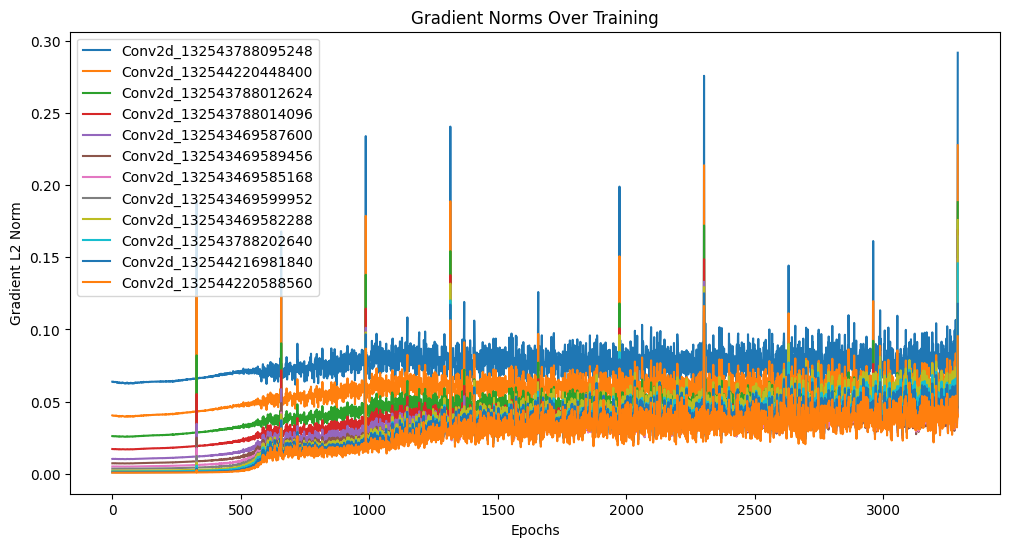

In [ ]:
gradient_norms = {}

def gradient_hook(module, grad_input, grad_output):
    if grad_output[0] is not None:
        grad_norm = grad_output[0].norm(p=2).item()
        layer_name = f"{module.__class__.__name__}_{id(module)}"

        if layer_name not in gradient_norms:
            gradient_norms[layer_name] = []

        gradient_norms[layer_name].append(grad_norm)

def register_hooks(model):
    for layer in model.features:
        if isinstance(layer, nn.Conv2d):
            layer.register_full_backward_hook(gradient_hook)

class VGGDeep_Gradient(nn.Module):
    def __init__(self, num_classes=3):
        super(VGGDeep_Gradient, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=False),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(inplace=False),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(inplace=False),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=False),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=False),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1), nn.ReLU(inplace=False),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=False),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=False),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 4096), nn.ReLU(inplace=False),
            nn.Linear(4096, 4096), nn.ReLU(inplace=False),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    register_hooks(model)

    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total

        val_loss, val_acc = evaluate_model(model, val_loader, criterion)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}]: Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    return train_losses, train_accuracies, val_losses, val_accuracies

def evaluate_model(model, data_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(data_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def plot_gradient_norms():
    plt.figure(figsize=(12, 6))

    for layer_name, norms in gradient_norms.items():
        plt.plot(norms, label=layer_name)

    plt.xlabel("Epochs")
    plt.ylabel("Gradient L2 Norm")
    plt.title("Gradient Norms Over Training")
    plt.legend()
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg_deep = VGGDeep_Gradient(num_classes=3).to(device)

initialize_xavier = lambda model: [nn.init.xavier_uniform_(p) for p in model.parameters() if len(p.shape) > 1]
initialize_xavier(vgg_deep)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg_deep.parameters(), lr=0.01)

print("\nTraining vgg deep model with gradient hook\n")
train_losses, train_accuracies, val_losses, val_accuracies = train_model(vgg_deep, train_loader, val_loader, optimizer, criterion, num_epochs=10)

test_loss, test_acc = evaluate_model(vgg_deep, test_loader, criterion)
print(f"\nTest Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")

plot_gradient_norms()


####The gradient norms for deeper layers progressively decrease throughout training, indicating the presence of vanishing gradients. This phenomenon suggests that deeper layers face challenges in learning effectively, potentially resulting in slower convergence and limited accuracy (74.76%).
####The plot illustrates the gradient norms of all convolutional layers across training batches over the epochs. Each layer is represented by a distinct color, with the L2 norm of gradients recorded at each batch iteration throughout the training process.

In [ ]:
torch.save(vgg_deep.state_dict(), "final_best_vgg_grad_model.pt")

In [ ]:
conv_layers = [name for name, module in vgg_deep.named_modules() if isinstance(module, nn.Conv2d)]
for idx, layer in enumerate(conv_layers):
    print(f"Layer {idx + 1}: {layer}")


Layer 1: features.0
Layer 2: features.2
Layer 3: features.5
Layer 4: features.7
Layer 5: features.10
Layer 6: features.12
Layer 7: features.14
Layer 8: features.16
Layer 9: features.19
Layer 10: features.21
Layer 11: features.23
Layer 12: features.25


####Gradient norms for subset of layers visualised

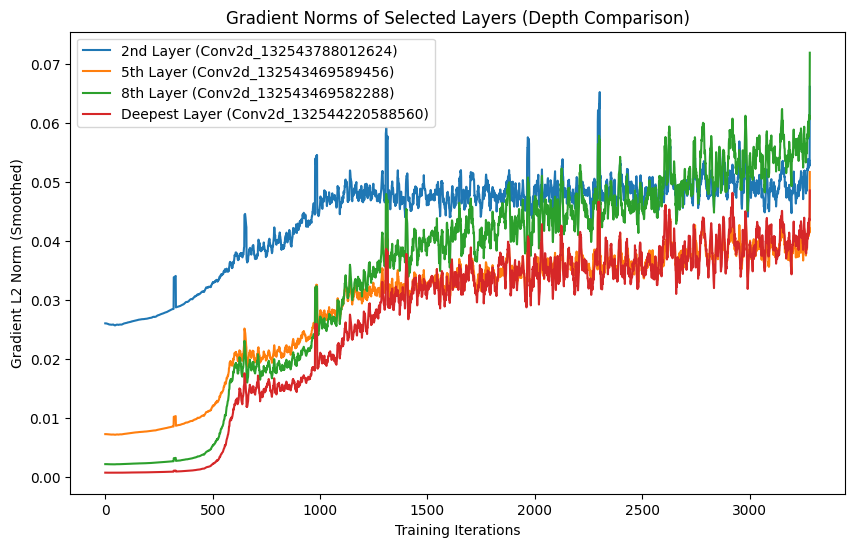

In [ ]:

def plot_selected_gradient_norms():

    plt.figure(figsize=(10, 6))


    conv_layer_names = list(gradient_norms.keys())


    if len(conv_layer_names) > 0:
        selected_layers = {
            2: "2nd Layer",
            5: "5th Layer",
            8: "8th Layer",
            len(conv_layer_names) - 1: "Deepest Layer"
        }

        for idx, label in selected_layers.items():
            if idx < len(conv_layer_names):
                layer_name = conv_layer_names[idx]
                norms = np.convolve(gradient_norms[layer_name], np.ones(10)/10, mode='valid')  # Smooth values
                plt.plot(norms, label=f"{label} ({layer_name})")

        plt.xlabel("Training Iterations")
        plt.ylabel("Gradient L2 Norm (Smoothed)")
        plt.title("Gradient Norms of Selected Layers (Depth Comparison)")
        plt.legend()
        plt.show()


plot_selected_gradient_norms()


### Inference: The above plot focuses on the selected subset of layers (2nd, 5th, 8th, and deepest convolutional layer) depth comparison. The gradients in deeper layers (red) are significantly smaller compared to previous layers, which shows the vanishing gradient problem, where gradients shrink as they propagate backward, making deeper layers harder to train.

**step 4**
####Best VGG and Resnet Models from part 1

In [ ]:
def train_model_vgg(model, train_loader, val_loader, optimizer, criterion, num_epochs=10, lr_scheduler=None, model_name="model"):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    writer = SummaryWriter(f'runs/{model_name}')

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()
                _, val_predicted = val_outputs.max(1)
                val_correct += (val_predicted == val_labels).sum().item()
                val_total += val_labels.size(0)

        val_loss /= len(val_loader)
        val_acc = 100. * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        if lr_scheduler:
            lr_scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        writer.add_scalar('Loss/Train', train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Train', train_acc, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)

    writer.close()
    return train_losses, train_accuracies, val_losses, val_accuracies


def evaluate_model_vgg(model, test_loader, criterion):
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_loader)
    test_acc = 100. * correct / total
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Evaluating Model")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    return test_loss, test_acc, cm, precision, recall, f1



def plot_training_curves(train_accuracies, val_accuracies, train_losses, val_losses, model_name):
    epochs = range(1, len(train_accuracies) + 1)
    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'{model_name} - Accuracy Over Epochs')


    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{model_name} - Loss Over Epochs')

    plt.show()


def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.show()



In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes=3, use_dropout=False):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 4096), nn.ReLU(inplace=True),
            nn.Dropout(0.5) if use_dropout else nn.Identity(),
            nn.Linear(4096, 4096), nn.ReLU(inplace=True),
            nn.Dropout(0.5) if use_dropout else nn.Identity(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg_model = VGG16(num_classes=3, use_dropout=True).to(device)


def initialize_xavier(model):
    for layer in model.modules():
        if isinstance(layer, (nn.Conv2d, nn.Linear)) and hasattr(layer, 'weight'):
            nn.init.xavier_uniform_(layer.weight)
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)

initialize_xavier(vgg_model)

vgg_optimizer = optim.Adam(vgg_model.parameters(), lr=0.001)

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, loss):
        if loss < self.best_loss - self.delta:
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1

        if self.counter >= self.patience:
            self.early_stop = True
        return self.early_stop

early_stopping_vgg = EarlyStopping(patience=5)

print("\nTraining BEST VGG Model with Early Stopping:")
train_loss_vgg, train_acc_vgg, val_loss_vgg, val_acc_vgg = train_model_vgg(
    vgg_model, train_loader, val_loader, vgg_optimizer, criterion, num_epochs=10
)

print("\nEvaluating Best VGG Model:")
test_loss_vgg, test_acc_vgg, cm_vgg, precision_vgg, recall_vgg, f1_vgg = evaluate_model_vgg(vgg_model, test_loader, criterion)



Training BEST VGG Model with Early Stopping:
Epoch [1/10], Train Loss: 0.6726, Train Acc: 69.98%, Val Loss: 0.5533, Val Acc: 76.60%
Epoch [2/10], Train Loss: 0.4413, Train Acc: 82.97%, Val Loss: 0.4226, Val Acc: 84.49%
Epoch [3/10], Train Loss: 0.3582, Train Acc: 86.70%, Val Loss: 0.3302, Val Acc: 86.91%
Epoch [4/10], Train Loss: 0.3027, Train Acc: 88.78%, Val Loss: 0.2659, Val Acc: 90.64%
Epoch [5/10], Train Loss: 0.2916, Train Acc: 89.48%, Val Loss: 0.2408, Val Acc: 90.71%
Epoch [6/10], Train Loss: 0.2568, Train Acc: 90.75%, Val Loss: 0.2251, Val Acc: 91.82%
Epoch [7/10], Train Loss: 0.2297, Train Acc: 91.62%, Val Loss: 0.2266, Val Acc: 92.40%
Epoch [8/10], Train Loss: 0.2316, Train Acc: 91.67%, Val Loss: 0.2148, Val Acc: 91.96%
Epoch [9/10], Train Loss: 0.2070, Train Acc: 92.45%, Val Loss: 0.2767, Val Acc: 90.18%
Epoch [10/10], Train Loss: 0.1973, Train Acc: 92.98%, Val Loss: 0.2185, Val Acc: 92.49%

Evaluating Best VGG Model:
Evaluating Model
Test Loss: 0.2160, Test Accuracy: 92.3

In [ ]:
torch.save(vgg_model.state_dict(), "final_best_vgg16_model.pt")

###Resnet model with it's best parameters

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return F.relu(out)

In [ ]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNet18, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = [ResidualBlock(in_channels, out_channels, stride)]
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [ ]:
def train_model_resnet(model, train_loader, val_loader, optimizer, criterion, num_epochs=10, lr_scheduler=None, model_name="model"):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    writer = SummaryWriter(f'runs/{model_name}')

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()
                _, val_predicted = val_outputs.max(1)
                val_correct += (val_predicted == val_labels).sum().item()
                val_total += val_labels.size(0)

        val_loss /= len(val_loader)
        val_acc = 100. * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        if lr_scheduler:
            lr_scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        writer.add_scalar('Loss/Train', train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Train', train_acc, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)

    writer.close()
    return train_losses, train_accuracies, val_losses, val_accuracies


def evaluate_model_resnet(model, test_loader, criterion):
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_loader)
    test_acc = 100. * correct / total
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Evaluating Model")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    return test_loss, test_acc, cm, precision, recall, f1


In [ ]:
best_resnet_model = ResNet18(num_classes=3).to(device)


def initialize_he(model):
    for layer in model.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)

initialize_he(best_resnet_model)


best_resnet_optimizer = optim.RMSprop(best_resnet_model.parameters(), lr=0.001)
best_resnet_lr_scheduler = optim.lr_scheduler.StepLR(best_resnet_optimizer, step_size=5, gamma=0.1)


class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, loss):
        if loss < self.best_loss - self.delta:
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

best_resnet_early_stopping = EarlyStopping(patience=5)


print("\nTraining BEST ResNet-18 Model with Early Stopping:")

best_resnet_train_losses, best_resnet_train_accuracies, best_resnet_val_losses, best_resnet_val_accuracies = [], [], [], []

for epoch in range(10):
    train_loss, train_acc, val_loss, val_acc = train_model_resnet(
        best_resnet_model, train_loader, val_loader, best_resnet_optimizer, criterion, num_epochs=1
    )

    best_resnet_train_losses.extend(train_loss)
    best_resnet_train_accuracies.extend(train_acc)
    best_resnet_val_losses.extend(val_loss)
    best_resnet_val_accuracies.extend(val_acc)

    best_resnet_lr_scheduler.step()

    if best_resnet_early_stopping(val_loss[-1]):
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

print("\nEvaluating BEST ResNet-18 Model:")
best_resnet_test_loss, best_resnet_test_acc, best_resnet_cm, best_resnet_precision, best_resnet_recall, best_resnet_f1 = evaluate_model_resnet(
    best_resnet_model, test_loader, criterion
)


best_resnet_results = {
    "test_loss": best_resnet_test_loss,
    "test_accuracy": best_resnet_test_acc,
    "confusion_matrix": best_resnet_cm,
    "precision": best_resnet_precision,
    "recall": best_resnet_recall,
    "f1_score": best_resnet_f1
}





Training BEST ResNet-18 Model with Early Stopping:
Epoch [1/1], Train Loss: 0.6230, Train Acc: 77.52%, Val Loss: 0.6531, Val Acc: 75.33%
Epoch [1/1], Train Loss: 0.4140, Train Acc: 84.25%, Val Loss: 1.7595, Val Acc: 59.33%
Epoch [1/1], Train Loss: 0.3350, Train Acc: 87.12%, Val Loss: 0.3212, Val Acc: 87.93%
Epoch [1/1], Train Loss: 0.3170, Train Acc: 88.19%, Val Loss: 0.3342, Val Acc: 87.47%
Epoch [1/1], Train Loss: 0.2742, Train Acc: 89.30%, Val Loss: 0.3962, Val Acc: 84.36%
Epoch [1/1], Train Loss: 0.2114, Train Acc: 91.91%, Val Loss: 0.2277, Val Acc: 91.36%
Epoch [1/1], Train Loss: 0.2013, Train Acc: 92.49%, Val Loss: 0.2241, Val Acc: 91.29%
Epoch [1/1], Train Loss: 0.1885, Train Acc: 93.00%, Val Loss: 0.2178, Val Acc: 91.73%
Epoch [1/1], Train Loss: 0.1786, Train Acc: 93.22%, Val Loss: 0.2138, Val Acc: 91.98%
Epoch [1/1], Train Loss: 0.1781, Train Acc: 93.33%, Val Loss: 0.2075, Val Acc: 92.07%

Evaluating BEST ResNet-18 Model:
Evaluating Model
Test Loss: 0.1843, Test Accuracy: 93.

In [ ]:
torch.save(best_resnet_model.state_dict(), "final_best_resnet18_model.pt")

### Plot comparison for 3 models: Deep VGG, VGG16, Resnet18

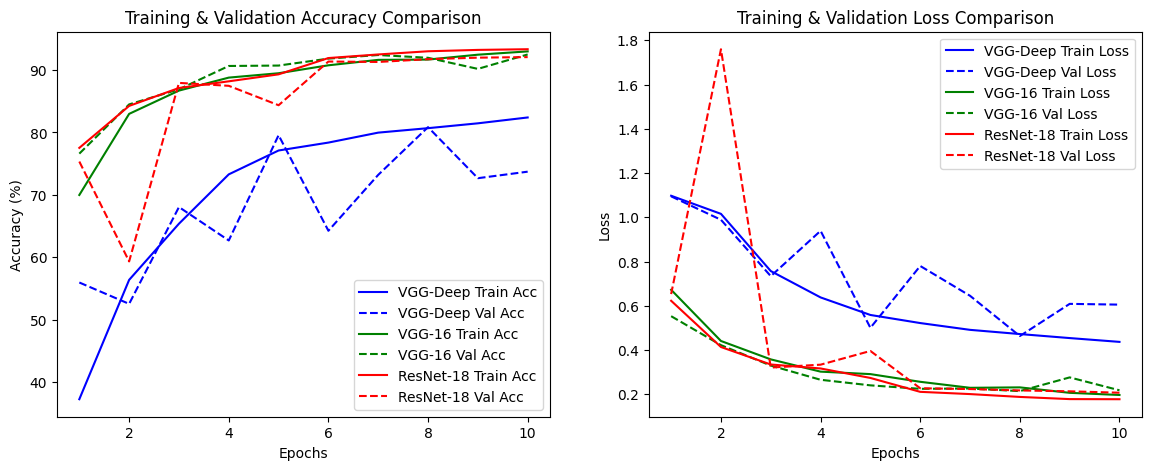

In [ ]:
def plot_comparison(train_acc_vggdeep, val_acc_vggdeep, train_loss_vggdeep, val_loss_vggdeep,
                    train_acc_vgg, val_acc_vgg, train_loss_vgg, val_loss_vgg,
                    train_acc_resnet, val_acc_resnet, train_loss_resnet, val_loss_resnet):

    epochs = range(1, len(train_acc_vggdeep) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc_vggdeep, 'b-', label='VGG-Deep Train Acc')
    plt.plot(epochs, val_acc_vggdeep, 'b--', label='VGG-Deep Val Acc')

    plt.plot(epochs, train_acc_vgg, 'g-', label='VGG-16 Train Acc')
    plt.plot(epochs, val_acc_vgg, 'g--', label='VGG-16 Val Acc')

    plt.plot(epochs, train_acc_resnet, 'r-', label='ResNet-18 Train Acc')
    plt.plot(epochs, val_acc_resnet, 'r--', label='ResNet-18 Val Acc')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training & Validation Accuracy Comparison')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss_vggdeep, 'b-', label='VGG-Deep Train Loss')
    plt.plot(epochs, val_loss_vggdeep, 'b--', label='VGG-Deep Val Loss')

    plt.plot(epochs, train_loss_vgg, 'g-', label='VGG-16 Train Loss')
    plt.plot(epochs, val_loss_vgg, 'g--', label='VGG-16 Val Loss')

    plt.plot(epochs, train_loss_resnet, 'r-', label='ResNet-18 Train Loss')
    plt.plot(epochs, val_loss_resnet, 'r--', label='ResNet-18 Val Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training & Validation Loss Comparison')

    plt.show()

plot_comparison(train_accuracies, val_accuracies, train_losses, val_losses,
                train_acc_vgg, val_acc_vgg, train_loss_vgg, val_loss_vgg,
                best_resnet_train_accuracies, best_resnet_val_accuracies,
                best_resnet_train_losses, best_resnet_val_losses)


### Inference: ResNet-18 shows best performance compared to VGG-16 and Deep VGG models, achieving the highest accuracy of 93.29% and lowest test loss 0.1843. Its residual connections improve gradient flow, which leads to faster convergence and better generalization. VGG-16 performs well but exhibits fluctuations, while VGG-Deep struggles with vanishing gradients, resulting in slower learning and higher loss. The accuracy and loss plots shows the ResNet-18’s stability and efficiency over the epochs.

**Step 5 :**

#### Defined train and test functions to experiment with different models

In [ ]:
#Training and Testing models:
def train_model_standard(model, train_loader, val_loader, optimizer, criterion, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total

        val_loss, val_acc = evaluate_model_standard(model, val_loader, criterion)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}]: Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    return train_losses, train_accuracies, val_losses, val_accuracies


def evaluate_model_standard(model, data_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(data_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


#### Experiment 1: Model with different Kernel sizes

In [ ]:
class VGGKernel(nn.Module):
    def __init__(self, kernel_size=3, num_classes=3):
        super(VGGKernel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=kernel_size, padding=kernel_size // 2), nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=kernel_size, padding=kernel_size // 2), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=kernel_size, padding=kernel_size // 2), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 16 * 16, 256), nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

# 3×3 kernel
model_3 = VGGKernel(kernel_size=3).to(device)
optimizer_3 = optim.Adam(model_3.parameters(), lr=0.001)
print("\nTraining model with 3x3 Kernel size\n")
train_losses_3, train_acc_3, val_losses_3, val_acc_3 = train_model_standard(
    model_3, train_loader, val_loader, optimizer_3, criterion, num_epochs=10)

# 5×5 kernel
model_5 = VGGKernel(kernel_size=5).to(device)
optimizer_5 = optim.Adam(model_5.parameters(), lr=0.001)
print("\nTraining model with 5x5 Kernel size\n")
train_losses_5, train_acc_5, val_losses_5, val_acc_5 = train_model_standard(
    model_5, train_loader, val_loader, optimizer_5, criterion, num_epochs=10)

# 7×7 kernel
model_7 = VGGKernel(kernel_size=7).to(device)
optimizer_7 = optim.Adam(model_7.parameters(), lr=0.001)
print("\nTraining model with 7x7 Kernel size\n")
train_losses_7, train_acc_7, val_losses_7, val_acc_7 = train_model_standard(
    model_7, train_loader, val_loader, optimizer_7, criterion, num_epochs=10)



Training model with 3x3 Kernel size

Epoch [1/10]: Train Loss: 0.4720 | Train Acc: 80.80% | Val Loss: 0.3751 | Val Acc: 85.31%
Epoch [2/10]: Train Loss: 0.3116 | Train Acc: 88.42% | Val Loss: 0.3173 | Val Acc: 87.93%
Epoch [3/10]: Train Loss: 0.2579 | Train Acc: 90.50% | Val Loss: 0.2509 | Val Acc: 90.20%
Epoch [4/10]: Train Loss: 0.2299 | Train Acc: 91.30% | Val Loss: 0.2442 | Val Acc: 90.58%
Epoch [5/10]: Train Loss: 0.2071 | Train Acc: 92.27% | Val Loss: 0.2386 | Val Acc: 91.24%
Epoch [6/10]: Train Loss: 0.1844 | Train Acc: 93.01% | Val Loss: 0.2381 | Val Acc: 91.16%
Epoch [7/10]: Train Loss: 0.1741 | Train Acc: 93.41% | Val Loss: 0.2410 | Val Acc: 91.27%
Epoch [8/10]: Train Loss: 0.1578 | Train Acc: 94.15% | Val Loss: 0.2572 | Val Acc: 90.84%
Epoch [9/10]: Train Loss: 0.1479 | Train Acc: 94.50% | Val Loss: 0.2491 | Val Acc: 91.24%
Epoch [10/10]: Train Loss: 0.1335 | Train Acc: 94.90% | Val Loss: 0.2127 | Val Acc: 92.02%

Training model with 5x5 Kernel size

Epoch [1/10]: Train Los

In [ ]:
test_loss_3, test_acc_3 = evaluate_model_standard(model_3, test_loader, criterion)
test_loss_5, test_acc_5 = evaluate_model_standard(model_5, test_loader, criterion)
test_loss_7, test_acc_7 = evaluate_model_standard(model_7, test_loader, criterion)

print(f"\nTest Results:")
print(f"3x3 Kernel - Test Loss: {test_loss_3:.4f} | Test Accuracy: {test_acc_3:.2f}%")
print(f"5x5 Kernel - Test Loss: {test_loss_5:.4f} | Test Accuracy: {test_acc_5:.2f}%")
print(f"7x7 Kernel - Test Loss: {test_loss_7:.4f} | Test Accuracy: {test_acc_7:.2f}%")



Test Results:
3x3 Kernel - Test Loss: 0.2050 | Test Accuracy: 92.64%
5x5 Kernel - Test Loss: 0.2382 | Test Accuracy: 91.47%
7x7 Kernel - Test Loss: 0.2962 | Test Accuracy: 89.87%


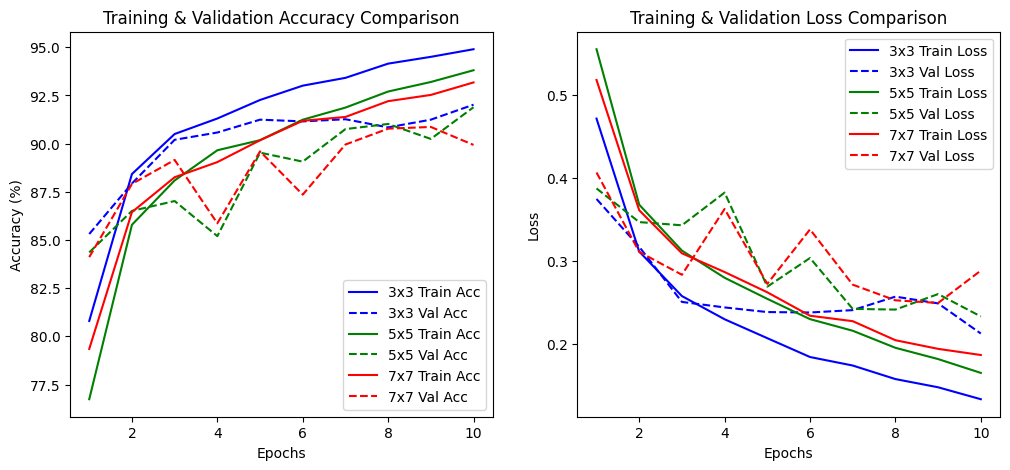

In [ ]:
epochs = range(1, 11)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_3, 'b-', label="3x3 Train Acc")
plt.plot(epochs, val_acc_3, 'b--', label="3x3 Val Acc")
plt.plot(epochs, train_acc_5, 'g-', label="5x5 Train Acc")
plt.plot(epochs, val_acc_5, 'g--', label="5x5 Val Acc")
plt.plot(epochs, train_acc_7, 'r-', label="7x7 Train Acc")
plt.plot(epochs, val_acc_7, 'r--', label="7x7 Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training & Validation Accuracy Comparison")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses_3, 'b-', label="3x3 Train Loss")
plt.plot(epochs, val_losses_3, 'b--', label="3x3 Val Loss")
plt.plot(epochs, train_losses_5, 'g-', label="5x5 Train Loss")
plt.plot(epochs, val_losses_5, 'g--', label="5x5 Val Loss")
plt.plot(epochs, train_losses_7, 'r-', label="7x7 Train Loss")
plt.plot(epochs, val_losses_7, 'r--', label="7x7 Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Comparison")
plt.legend()

plt.show()


###Inference: The results shows that the model with 3x3 kernel achieved the highest test accuracy of 92.64% with the lowest test loss of 0.2050, while the 5x5 kernel had a slightly lower accuracy of 91.47% and a test loss of 0.2382. The 7x7 kernel performed the least, with an accuracy of 89.87% and the highest test loss of 0.2962. This suggests that smaller kernels such as 3x3, offers better balance between feature extraction and generalization. Larger kernels, such as 5x5 and 7x7, capture more spatial context but introduce redundancy and overfitting.

#### Experiment with and without 1x1 convolutional layers

In [ ]:
#model WITHOUT 1x1 Convolution
class VGG_without_1x1(nn.Module):
    def __init__(self, num_classes=3):
        super(VGG_without_1x1, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 16 * 16, 256), nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

#model WITH 1x1 Convolution
class VGG_with_1x1(nn.Module):
    def __init__(self, num_classes=3):
        super(VGG_with_1x1, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 16 * 16, 256), nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [ ]:
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_without_1x1 = VGG_without_1x1(num_classes=3).to(device)
model_with_1x1 = VGG_with_1x1(num_classes=3).to(device)

print("\nModel WITHOUT 1x1 Convolutions")
summary(model_without_1x1, (3, 64, 64))

print("\nModel WITH 1x1 Convolutions")
summary(model_with_1x1, (3, 64, 64))



Model WITHOUT 1x1 Convolutions
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
              ReLU-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          18,496
              ReLU-4           [-1, 64, 64, 64]               0
         MaxPool2d-5           [-1, 64, 32, 32]               0
            Conv2d-6          [-1, 128, 32, 32]          73,856
              ReLU-7          [-1, 128, 32, 32]               0
         MaxPool2d-8          [-1, 128, 16, 16]               0
            Linear-9                  [-1, 256]       8,388,864
             ReLU-10                  [-1, 256]               0
           Linear-11                    [-1, 3]             771
Total params: 8,482,883
Trainable params: 8,482,883
Non-trainable params: 0
-----------------------------------------------------------

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer_no_1x1 = optim.Adam(model_without_1x1.parameters(), lr=0.001)
print("\nTraining without 1x1 Convolution layer")
train_losses_no_1x1, train_acc_no_1x1, val_losses_no_1x1, val_acc_no_1x1 = train_model_standard(
    model_without_1x1, train_loader, val_loader, optimizer_no_1x1, criterion, num_epochs=10)

optimizer_with_1x1 = optim.Adam(model_with_1x1.parameters(), lr=0.001)
print("\nTraining with 1x1 Convolution layer")
train_losses_with_1x1, train_acc_with_1x1, val_losses_with_1x1, val_acc_with_1x1 = train_model_standard(
    model_with_1x1, train_loader, val_loader, optimizer_with_1x1, criterion, num_epochs=10)

test_loss_no_1x1, test_acc_no_1x1 = evaluate_model_standard(model_without_1x1, test_loader, criterion)
test_loss_with_1x1, test_acc_with_1x1 = evaluate_model_standard(model_with_1x1, test_loader, criterion)

print(f"\nTest Results:")
print(f"Without 1x1 - Test Loss: {test_loss_no_1x1:.4f} | Test Accuracy: {test_acc_no_1x1:.2f}%")
print(f"With 1x1 - Test Loss: {test_loss_with_1x1:.4f} | Test Accuracy: {test_acc_with_1x1:.2f}%")



Training without 1x1 Convolution layer
Epoch [1/10]: Train Loss: 0.5354 | Train Acc: 78.01% | Val Loss: 0.3833 | Val Acc: 84.93%
Epoch [2/10]: Train Loss: 0.3601 | Train Acc: 85.89% | Val Loss: 0.3355 | Val Acc: 87.04%
Epoch [3/10]: Train Loss: 0.2933 | Train Acc: 88.96% | Val Loss: 0.3171 | Val Acc: 88.47%
Epoch [4/10]: Train Loss: 0.2521 | Train Acc: 90.43% | Val Loss: 0.3156 | Val Acc: 88.07%
Epoch [5/10]: Train Loss: 0.2294 | Train Acc: 91.38% | Val Loss: 0.2644 | Val Acc: 89.93%
Epoch [6/10]: Train Loss: 0.2081 | Train Acc: 92.21% | Val Loss: 0.2279 | Val Acc: 91.04%
Epoch [7/10]: Train Loss: 0.1875 | Train Acc: 92.99% | Val Loss: 0.2528 | Val Acc: 90.22%
Epoch [8/10]: Train Loss: 0.1690 | Train Acc: 93.50% | Val Loss: 0.2441 | Val Acc: 90.67%
Epoch [9/10]: Train Loss: 0.1579 | Train Acc: 93.88% | Val Loss: 0.2325 | Val Acc: 91.24%
Epoch [10/10]: Train Loss: 0.1462 | Train Acc: 94.48% | Val Loss: 0.2185 | Val Acc: 92.00%

Training with 1x1 Convolution layer
Epoch [1/10]: Train Lo

#### The VGG model without 1x1 convolutions outperforms the version with 1x1 convolutions in terms of both test accuracy (92.73 % and 91.47%)and test loss (0.2023 and 0.2297). The model without 1x1 convolutions shows faster training progress with higher accuracy in the early epochs, reaching 92% validation accuracy by epoch 10. In contrast, the model with 1x1 convolutions shows slower training convergence and slightly lower validation accuracy (91.22% and 92%). The slight drop in accuracy shows that, the simple model without 1x1 convolutions is more effective in capturing the features and also maintains efficient computation.

5d

#### Experiment with 4 different Activation Functions: ReLu, Leaky ReLu, Elu, and Gelu

In [ ]:
class VGG_Activation(nn.Module):
    def __init__(self, activation, num_classes=3):
        super(VGG_Activation, self).__init__()
        self.activation = activation

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), self.activation,
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1), self.activation,
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(64 * 16 * 16, 256), self.activation,
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_relu = VGG_Activation(nn.ReLU(inplace=True)).to(device)
model_leaky_relu = VGG_Activation(nn.LeakyReLU(0.01, inplace=True)).to(device)
model_elu = VGG_Activation(nn.ELU(alpha=1.0, inplace=True)).to(device)
model_gelu = VGG_Activation(nn.GELU()).to(device)

print("\nModel with ReLU Activation")
summary(model_relu, (3, 64, 64))

print("\nModel with Leaky ReLU Activation")
summary(model_leaky_relu, (3, 64, 64))

print("\nModel with ELU Activation")
summary(model_elu, (3, 64, 64))

print("\nModel with GELU Activation")
summary(model_gelu, (3, 64, 64))



Model with ReLU Activation
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
              ReLU-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
              ReLU-4           [-1, 32, 64, 64]               0
         MaxPool2d-5           [-1, 32, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]          18,496
              ReLU-7           [-1, 64, 32, 32]               0
              ReLU-8           [-1, 64, 32, 32]               0
              ReLU-9           [-1, 64, 32, 32]               0
        MaxPool2d-10           [-1, 64, 16, 16]               0
           Linear-11                  [-1, 256]       4,194,560
             ReLU-12                  [-1, 256]               0
             ReLU-13                  [-1, 256]               0
           

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer_relu = optim.Adam(model_relu.parameters(), lr=0.001)
print("\nTraining model with ReLU Activation function")
train_relu, acc_relu, val_relu, val_acc_relu = train_model_standard(
    model_relu, train_loader, val_loader, optimizer_relu, criterion, num_epochs=10)

optimizer_leaky_relu = optim.Adam(model_leaky_relu.parameters(), lr=0.001)
print("\nTraining model with Leaky ReLU Activation function")
train_leaky_relu, acc_leaky_relu, val_leaky_relu, val_acc_leaky_relu = train_model_standard(
    model_leaky_relu, train_loader, val_loader, optimizer_leaky_relu, criterion, num_epochs=10)

optimizer_elu = optim.Adam(model_elu.parameters(), lr=0.001)
print("\nTraining model with ELU Activation function")
train_elu, acc_elu, val_elu, val_acc_elu = train_model_standard(
    model_elu, train_loader, val_loader, optimizer_elu, criterion, num_epochs=10)

optimizer_gelu = optim.Adam(model_gelu.parameters(), lr=0.001)
print("\nTraining model with GELU Activation function")
train_gelu, acc_gelu, val_gelu, val_acc_gelu = train_model_standard(
    model_gelu, train_loader, val_loader, optimizer_gelu, criterion, num_epochs=10)



Training model with ReLU Activation function
Epoch [1/10]: Train Loss: 0.4823 | Train Acc: 80.32% | Val Loss: 0.3655 | Val Acc: 85.24%
Epoch [2/10]: Train Loss: 0.3290 | Train Acc: 87.30% | Val Loss: 0.2909 | Val Acc: 88.78%
Epoch [3/10]: Train Loss: 0.2840 | Train Acc: 89.20% | Val Loss: 0.3383 | Val Acc: 86.78%
Epoch [4/10]: Train Loss: 0.2574 | Train Acc: 90.19% | Val Loss: 0.2659 | Val Acc: 89.29%
Epoch [5/10]: Train Loss: 0.2356 | Train Acc: 91.07% | Val Loss: 0.2629 | Val Acc: 89.62%
Epoch [6/10]: Train Loss: 0.2209 | Train Acc: 91.57% | Val Loss: 0.2681 | Val Acc: 89.80%
Epoch [7/10]: Train Loss: 0.1981 | Train Acc: 92.63% | Val Loss: 0.2665 | Val Acc: 89.73%
Epoch [8/10]: Train Loss: 0.1821 | Train Acc: 93.13% | Val Loss: 0.2698 | Val Acc: 90.18%
Epoch [9/10]: Train Loss: 0.1632 | Train Acc: 93.74% | Val Loss: 0.2783 | Val Acc: 89.80%
Epoch [10/10]: Train Loss: 0.1465 | Train Acc: 94.45% | Val Loss: 0.2594 | Val Acc: 90.47%

Training model with Leaky ReLU Activation function
E

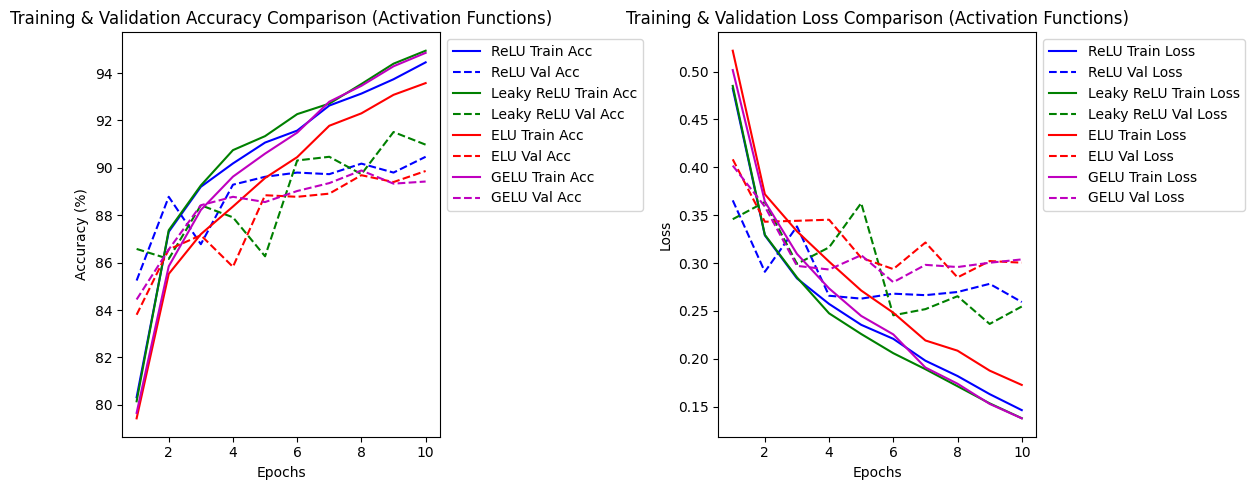

In [ ]:
epochs = range(1, 11)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc_relu, 'b-', label="ReLU Train Acc")
plt.plot(epochs, val_acc_relu, 'b--', label="ReLU Val Acc")
plt.plot(epochs, acc_leaky_relu, 'g-', label="Leaky ReLU Train Acc")
plt.plot(epochs, val_acc_leaky_relu, 'g--', label="Leaky ReLU Val Acc")
plt.plot(epochs, acc_elu, 'r-', label="ELU Train Acc")
plt.plot(epochs, val_acc_elu, 'r--', label="ELU Val Acc")
plt.plot(epochs, acc_gelu, 'm-', label="GELU Train Acc")
plt.plot(epochs, val_acc_gelu, 'm--', label="GELU Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training & Validation Accuracy Comparison (Activation Functions)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

plt.subplot(1, 2, 2)
plt.plot(epochs, train_relu, 'b-', label="ReLU Train Loss")
plt.plot(epochs, val_relu, 'b--', label="ReLU Val Loss")
plt.plot(epochs, train_leaky_relu, 'g-', label="Leaky ReLU Train Loss")
plt.plot(epochs, val_leaky_relu, 'g--', label="Leaky ReLU Val Loss")
plt.plot(epochs, train_elu, 'r-', label="ELU Train Loss")
plt.plot(epochs, val_elu, 'r--', label="ELU Val Loss")
plt.plot(epochs, train_gelu, 'm-', label="GELU Train Loss")
plt.plot(epochs, val_gelu, 'm--', label="GELU Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Comparison (Activation Functions)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


#### Leaky ReLU demonstrated the highest validation accuracy (91.51%), outperforming ReLU (90.47%), ELU (89.87%), and GELU (89.42%). ReLU function provided stable training but was prone to inactive neurons, limiting its effectiveness. Leaky ReLU effectively mitigated this issue, leading to improved performance. ELU exhibited stable learning but converged more slowly.Despite its smooth activation characteristics, GELU function did not exceed the performance of Leaky ReLU function.

**5 e**
####Visualizing Normalized first convolutional layers VGG and Resnet models

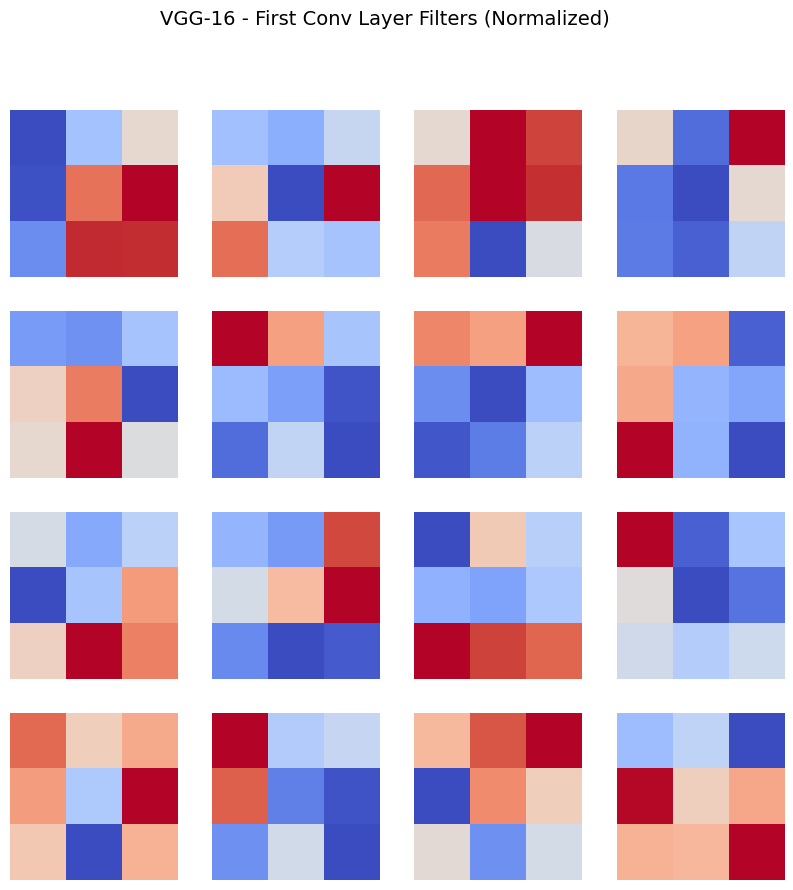

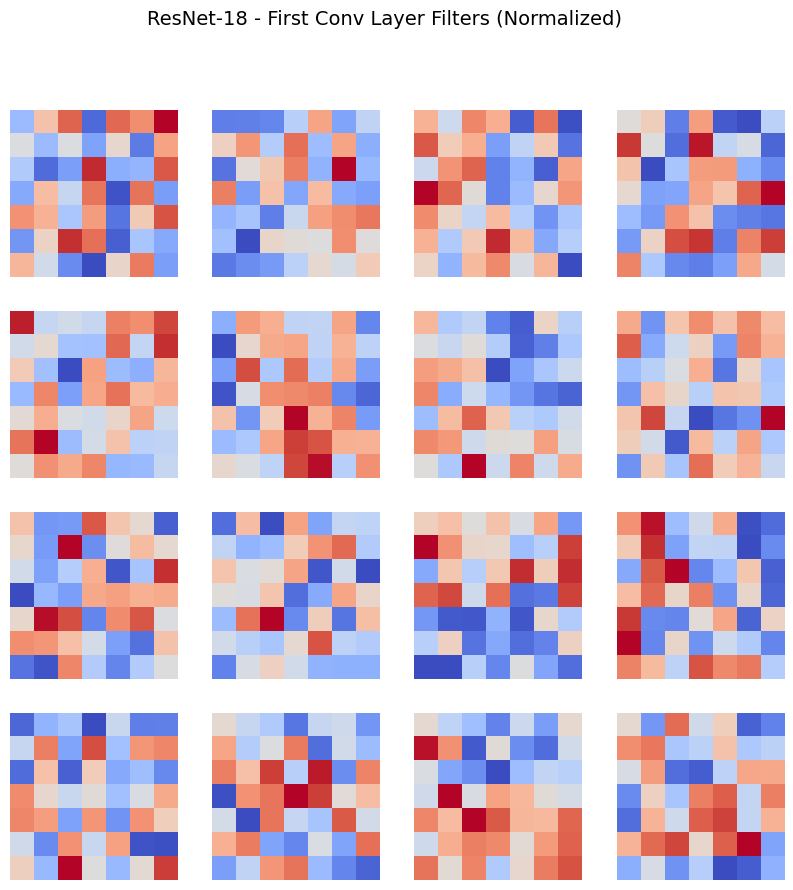

In [ ]:
def normalize_filters(filters):

    min_val = filters.min()
    max_val = filters.max()
    return (filters - min_val) / (max_val - min_val)

def visualize_filters(model, model_name, layer_idx=0, num_filters=16):
    model_weights = model.state_dict()

    first_conv_layer = None
    for name, param in model.named_parameters():
        if "conv1.weight" in name or "features.0.weight" in name:
            first_conv_layer = param
            break

    if first_conv_layer is None:
        print(f"No convolutional layer found in {model_name}")
        return

    filters = first_conv_layer.data.cpu().numpy()

    filters = normalize_filters(filters)

    grid_size = int(np.ceil(np.sqrt(num_filters)))

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    fig.suptitle(f"{model_name} - First Conv Layer Filters (Normalized)", fontsize=14)

    for i, ax in enumerate(axes.flat):
        if i < filters.shape[0]:

            filter_img = filters[i, 0, :, :]
            ax.imshow(filter_img, cmap="coolwarm")
            ax.axis("off")

    plt.show()


vgg_model.load_state_dict(torch.load("final_best_vgg16_model.pt", weights_only=True))
best_resnet_model.load_state_dict(torch.load("final_best_resnet18_model.pt", weights_only=True))

visualize_filters(vgg_model, "VGG-16")
visualize_filters(best_resnet_model, "ResNet-18")


####Inference: The first convolutional layer filters in VGG-16 and ResNet-18 shows clear differences in processing the features. VGG-16 filters have more organized and distinct patterns, with larger uniform regions, which indicates the focus on basic features like simple edges. In contrast, ResNet-18 filters exhibit deeper details, with more variation and higher frequency patterns, which indicates that it captures more complex textures and spatial details.

**Step 6:**



####a. Analysis of gradient norm plots:
The gradient norms plot shows a hierarchical pattern where deeper layers consistently exhibit higher gradient magnitudes compared to previous layers.This shows the vanishing gradient problem, where gradients decrease as they move backward, making the early layers to learn slow.
In gradient norms pattern the 2nd layer (blue line) consistently exhibits higher gradient magnitudes compared to deeper layers
This pattern demonstrates the vanishing gradient problem, where gradient magnitudes diminish as they propagate backward through the network.
The 2nd layer shows gradient norms approximately 1.5 times larger than those in the deepest layer by the end of training.

####b.Gradient Vanishing Problem
During backpropagation, gradients are calculated by multiplying derivatives from the output layer to earlier layers. In deep networks, small values such as derivatives of activation function are repeatedly multiplied, causing an exponential decrease in the gradient magnitude. Thus the deeper layers in networks receive much smaller gradients and learn more slowly, demonstrating the vanishing gradient problem.


####c.Resnet's Architecture
ResNet addresses the vanishing gradient problem by introducing residual connections, which act as shortcut that allows gradients to bypass layers through identity mappings. Instead of learning a direct transformation, ResNet models the residual function as F(x) + x, where x represents the identity mapping. During backpropagation, the gradient can flow directly through these identity connections without being affected by weight multiplications, effectively creating a gradient highway. This approach ensures that even deep layers receive meaningful gradient signals,as a result networks with over 100 layers can train effectively, with early layers still learning efficiently despite the depth of the network.

####d.Batch Normalization Impact
Batch normalization helps reduce gradient issues by stabilizing the activation functions during training process. It normalizes the inputs of each layer to have a zero mean and unit variance, which prevents the values from becoming too large or small. This process also reduces dependency between layers, which helps avoid error accumulation. By regulating activation scales, batch normalization also prevents extreme values that could cause exploding gradients.

####e.Observations:
1. Different Kernel sizes:
The 3x3 kernel gave the highest accuracy (92.64%) and lowest test loss, whereas larger kernels (5x5, 7x7) exhibited reduced performance due to increased redundancy and overfitting.
2. Model with and without 1x1 Convolutional layers:
The VGG model without 1x1 convolutional layer obtained higher test accuracy (92.73%) and better convergence, while the model with 1x1 convolution showed slow training and slightly lower accuracy (91.47%), which indicates better feature extraction from simple model without 1x1 convolutions.
3. Different Activation Functions:
Leaky ReLU activation performed better than other activation functions by preventing inactive neurons and ensures better gradient flow, leading to higher accuracy.Its effectiveness in reducing the problem of neurons becoming inactive helps in performance compared to ReLU, ELU, and GELU activation function.
4. Visualizing first convolutional layer filters:
VGG-16 filters emphasize basic features such as edges, whereas ResNet-18 filters capture more complex textures and spatial details in depth.

##References:
https://pytorch.org/vision/main/models/vgg.html


https://pytorch.org/vision/main/transforms.html

https://colab.research.google.com/drive/1xM63CddwQM5gDNtiUMBNwnfXE4a4vXgD

https://colab.research.google.com/drive/1VKsN5-4dhfvrmtPkzpOz4Sdsuo9rQ5Nm